In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
%matplotlib inline
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')
# Для отрисовки дерева
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

### Метрики качества

http://www.machinelearning.ru/wiki/images/f/fd/PZAD2017_03_errors.pdf

https://alexanderdyakonov.files.wordpress.com/2018/10/book_08_metrics_12_blog1.pdf

Метрики качества нужны для оценки качества работы модели. Иногда само устройтво метрики помогает понять, на каких именно объектах алгоритм хуже\лучше всего себя ведёт и что можно улучшить.

#### Метрики качества в задаче регресии

#### Метрики качества в задаче классификации

Загрузим набор рукописных цифр

In [3]:
%%time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
mnist = fetch_openml('mnist_784')
X_tr, X_te, y_tr, y_te = train_test_split(mnist['data'], mnist['target'].astype(int), test_size=0.3, shuffle=True)

Wall time: 54.4 s


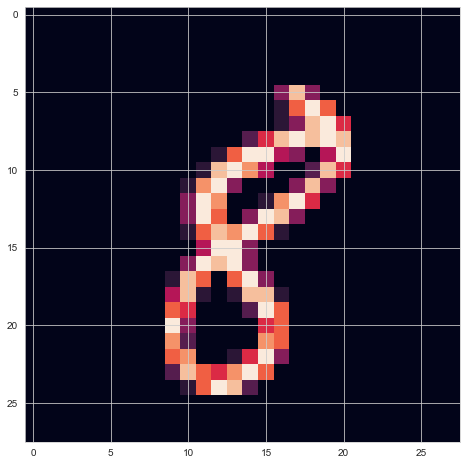

In [4]:
plt.imshow(X_tr[12].reshape(28, 28));

Обучим логистическую регрессию

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
lr = LogisticRegression()
lr.fit(X_tr[:1000], y_tr[:1000])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Получим предсказания и будем оценивать качества предсказаний

In [7]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

Введём некоторые обозначения:

n - общее число объектов, k $\in \{1, 2, \dots, K \}, \ K $ - общее число классов.

$x_{i}, y_{i}$ - признаковое описание i-ого объекта и его метка соответственно

$a(x_{i})$ - предсказание на i-ом объекте

$[...]$ - индикатор выражения, который принимает значение 1, если ... - истинно и 0 иначе.

Тогда:

<p>&#9679; $TP_{k} = \sum\limits_{i = 1}^n [a(x_{i}) = k] \cdot [y_{i} = k]$ - число объектов, правильно отнесённых к k-ому классу. </p>

<p>&#9679; $TN_{k} = \sum\limits_{i = 1}^n [a(x_{i}) \not = k] \cdot [y_{i} \not = k]$ - число объектов, правильно НЕотнесённых к k-ому классу. </p>

<p>&#9679; $FP_{k} = \sum\limits_{i = 1}^n [a(x_{i}) = k] \cdot [y_{i} \not = k]$ - число объектов, НЕправильно отнесённых к k-ому классу. </p>

<p>&#9679; $FN_{k} = \sum\limits_{i = 1}^n [a(x_{i}) \not \not = k] \cdot [y_{i} = k]$ - число объектов, НЕправильно НЕотнесённых к k-ому классу. </p>

In [30]:
y_pred = lr.predict(X_te)
conf_mat = confusion_matrix(y_te, y_pred).T

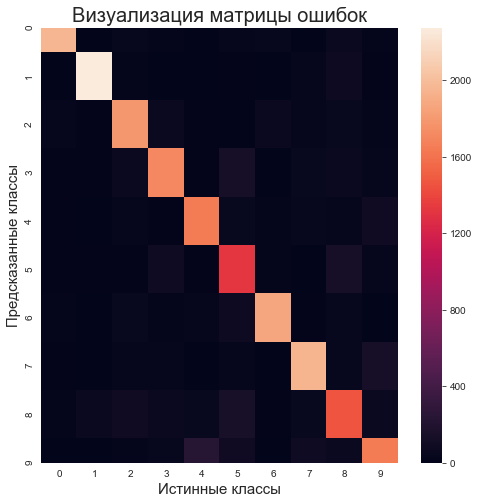

In [31]:
sns.heatmap(conf_mat);
plt.title('Визуализация матрицы ошибок', fontsize=20);
plt.xlabel('Истинные классы', fontsize=15);
plt.ylabel('Предсказанные классы', fontsize=15);

### Выбор модели

https://alexanderdyakonov.files.wordpress.com/2015/04/ama2015_scikit.pdf

In [3]:
from sklearn.model_selection import learning_curve

### Интерпретация моделей
https://christophm.github.io/interpretable-ml-book/interpretability.html

https://habr.com/ru/company/otus/blog/465329/

В мире анализа данных очень важным качеством модели является её интерпретируемость. Многие бизнес решения склоняются в пользу более простых моделей с меньшим качеством, ввиду лучшей интерпретируемости таких моделей. Если модель не поддаётся интерпретации, то её с меньшей охотой внедряют в продакшн, ведь нельзя проанализировать, на каких объектах эта модель поведёт анамально и почему она так себя повела. 

Однако и для сложных нелинейных моделей (деревья решений, нейронные сети и т.д.) существуют способы интерпретации и анализа их работы. 

Начнём с простейших линейных моделей - линейная и логистическая регрессии.

<font color='red'>Линейная регрессия</font> это модель вида: $y = w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d}, \ y \in \mathbb{R}$. Линейной она называется потому, что эта модель <b><i>линейная по параметрам ($w_{k}$)</i></b>, то есть модель $y = w_{0} + w_{1} \cdot x_{1}^2 + w_{2} \cdot x_{1}^3$ тоже будет называться линейной регрессией.

Её любят статистики за простую интерпретируемость. 

Рассмотрим на примере.

Пусть есть модель зависимости стоимости квартиры (млн. Руб.) от различных характеристик квартиры: 

$$price = 3 + 2 \cdot n\_rooms + 0.3 \cdot metro\_dist - 0.1 \cdot floor$$

Тогда коэффициент при n\_rooms можно проинтерпретировать так: 

При прочих равных условиях (а именно, если мы будем рассматривать множество квартир, отличающихся только количеством комнат), при увеличении числа комнат в квартире на 1 общая цена квартиры растёт <b>в среднем</b> на 2 млн. руб. 

При floor: При прочих равных условиях, при этажа на котором располагается квартира на 1 общая цена квартиры падает <b>в среднем</b> на 100 тыс. руб. (0.1 млн. руб.) 

Рассмотрим вариации этой модели и как будет меняться интерпретация в зависимости от вида линейной регрессии:

1) $y = w \cdot \ln x$

При прочих равных условиях при увеличении переменной x на $\boxed{1 \%}$ переменная y меняется на $\boxed{w \cdot 100 \ единиц}$

2) $\ln y = w \cdot x$

При прочих равных условиях при увеличении переменной x на $\boxed{1 \ единицу}$ переменная y меняется на $\boxed{(e^{w} - 1) \cdot 100\%}$

3) $\ln y = w \cdot \ln x$

При прочих равных условиях при увеличении переменной x на $\boxed{1\%}$ переменная y меняется на $\boxed{w\%}$

Однако с линейной регрессией нужно умень оценивать адекватность модели для того, чтобы можно было проводить такую интерпретацию коэффициентов. В случае наличиня [мультиколлинеарности](https://ru.wikipedia.org/wiki/Мультиколлинеарность) в модели оценки теряют интерпретируемость.

Рассмотрим пример.

Пусть была оценена линейная регрессия со следующими параметрами

$$y = 3 + 5 \cdot x  - 3 \cdot w + 15 \cdot z$$

Но пусть так же известно, что переменные x и w связаны соотношением: $z = 2 \cdot x - 7 \cdot w \Rightarrow z - 2 \cdot x + 7 \cdot w = 0$

Тогда: $y = 3 + 5 \cdot x  - 3 \cdot w + 15 \cdot z + 0 = 3 + 5 \cdot x  - 3 \cdot w + 15 \cdot z + (z - 2 \cdot x + 7 \cdot w) = 3 + 3 \cdot x + 4 \cdot w + 16 \cdot z$

Получаем совсем другие коэффициенты перед признаками, однако само уравнение по прежнему точно так же описывает y, как и изначальное уравнение.

<font color='red'>Логистическая регрессия</font> это модель вида: $\mathbb{P}(y = 1 | x_{1}, \dots, x_{n}) = \sigma(w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d}), \ y \in \{ 0, 1 \}, \ \sigma(z) = \frac{1}{1 + e^{-z}}$. Это тоже считается линейной моделью, так как если мы сделаем преобразование $\mathbb{P}(y = 1 | x_{1}, \dots, x_{n}) \to \ln\left(\frac{\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})}{1-\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})}\right)$, то модель будет иметь вид обычной линейной регрессии: $\ln\left(\frac{\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})}{1-\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})}\right) = w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d}$

Заметим, что в линейной регрессии мы интерпретировали коэффициенты так: как поменяется y, в результате изменения x. Иными словами, мы хотели понять: $\Delta x \to \Delta y$. Вспомним, что $\Delta y \approx y^{\prime} \cdot \Delta x$. Тогда в логистической регрессии можно интерпретировать коэффициент $w_{k}$ так: $\Delta P(y = 1) = \sigma(w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d})^{\prime}_{x_{k}} \cdot w_{k} \cdot \Delta x$. Для логистической функции известно, что $\sigma(z)' = \sigma(z) \cdot (1 - \sigma(z))$.

Окончательно имеем: При увеличении $x_{k}$ на 1 единицу $\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})$ изменяется на $\sigma(w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d}) \cdot (1 - \sigma(w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d})) \cdot w_{k}$ единиц.

Рассмотрим пример.

600 водителей, выбранных случайным образом, попросили
пройти специальный тест на вождение автомобилем. Для каждого водителя были собраны следующие данные: Pass — фиктивная переменная,
равная единице, если водитель сдал тест, Male — фиктивная переменная,
равная единице, если водитель мужчина, и равная 0, если водитель женщина, Experience — опыт вождения автомобилем (в годах). Оценённая модель логистической регрессии имеет вид:

$$\mathbb{P}(y = 1 | Expeience, Male) = \sigma(0.8 + 0.08 \cdot Experience - 0.17 \cdot Male - 0.04 \cdot Male \cdot Experience)$$

Проинтерпретируем как меняется выроятность для мужчины сдать тест при увеличении стажа на 1 год (если его текущий стаж равен 5 годам). Для мужчины модель принимает вид: 

$$\mathbb{P}(y = 1 | Expeience, Male) = \sigma(0.63 + 0.04 \cdot Experience)$$

Получаем: При прочих равных условиях, при увеличении опыта вождения на 1 год вероятность сдать тест увеличивается на $\sigma(0.63 + 0.04 \cdot Experience) \cdot (1 - \sigma(0.63 + 0.04 \cdot Experience)) \cdot 0.04 = \sigma(0.63 + 0.04 \cdot 5) \cdot (1 - \sigma(0.63 + 0.04 \cdot 5)) \cdot 0.04 \approx 0.008 \ $ (примерно 1%)


In [3]:
from sklearn.datasets import load_boston

In [4]:
dat = pd.DataFrame(np.c_[load_boston()['data'], load_boston()['target']], 
                   columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])
dat.columns = [col.lower() for col in dat.columns]
dat.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000's

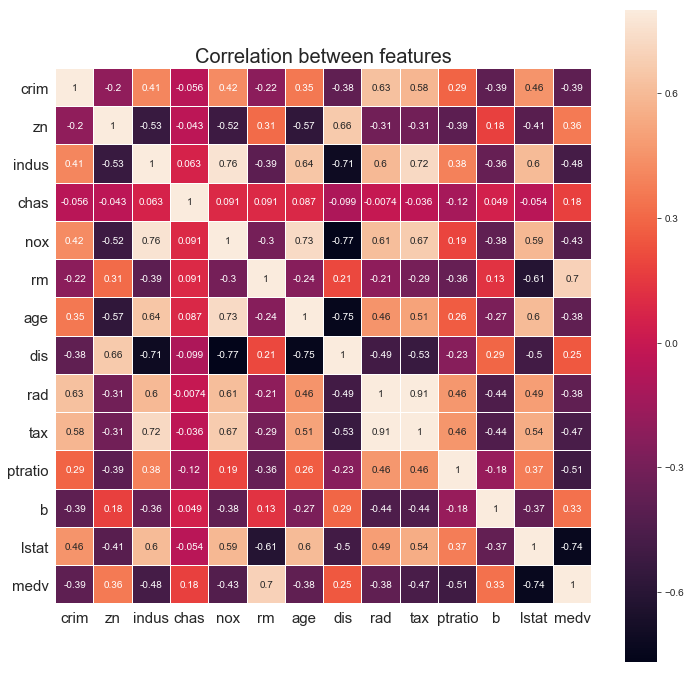

In [86]:
plt.figure(figsize=(12, 12))
sns.heatmap(dat.corr(), vmax=.8, linewidths=0.01,
            square=True, annot=True, cmap=None, linecolor="white")
plt.title('Correlation between features', fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15, rotation=0);

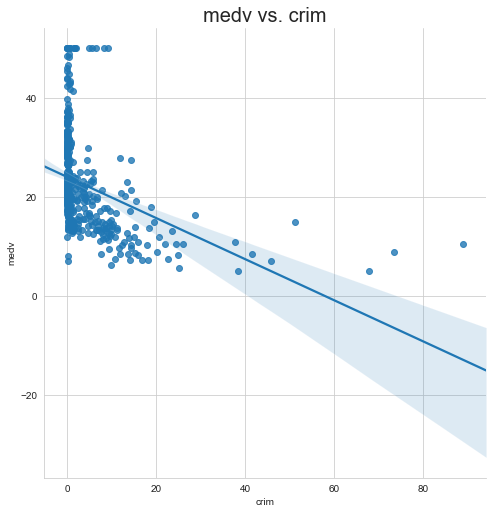

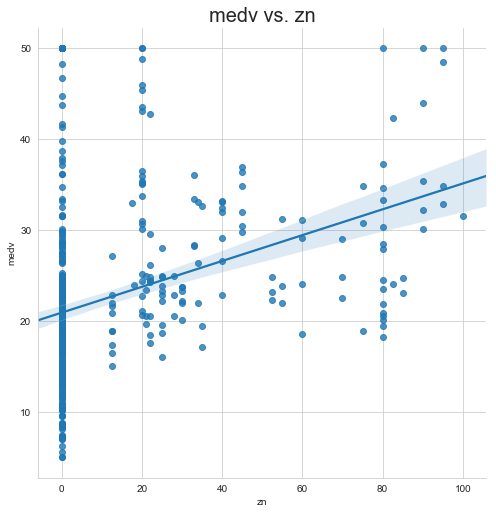

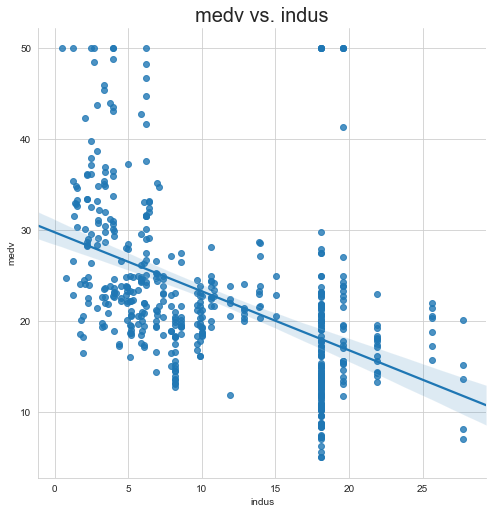

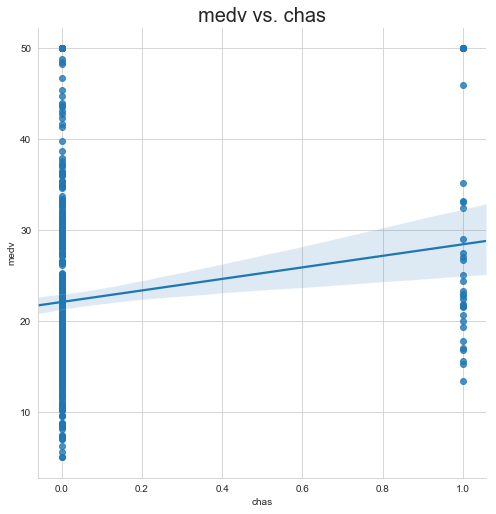

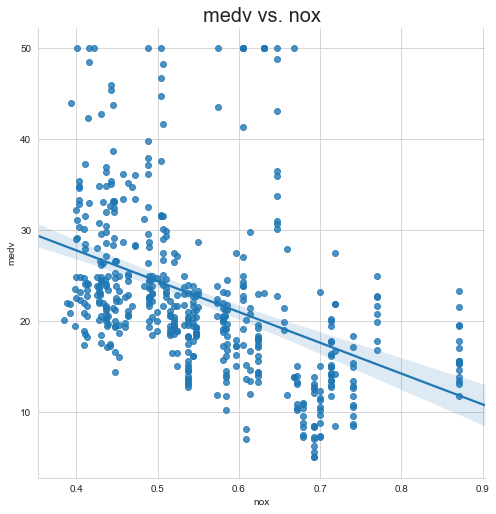

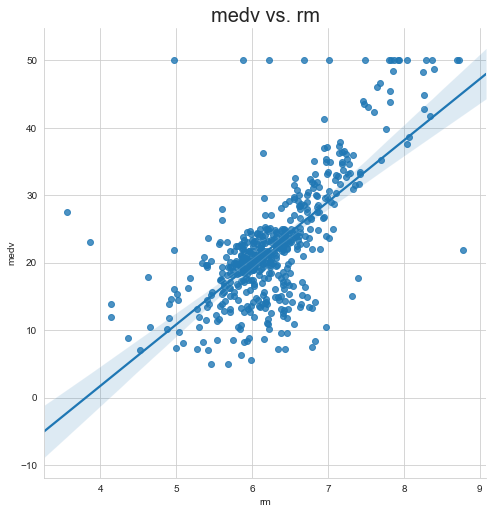

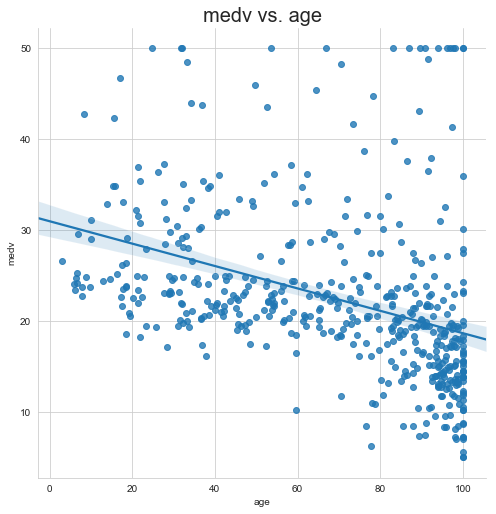

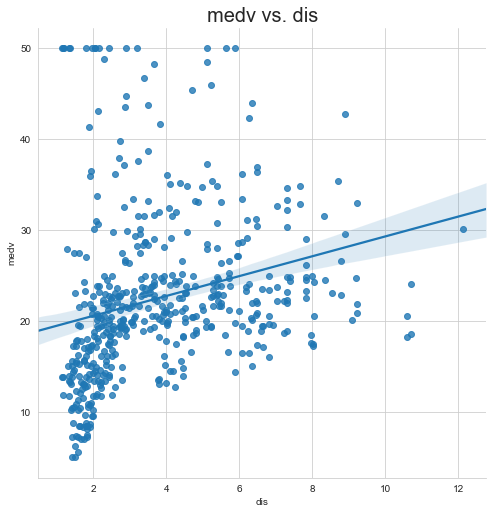

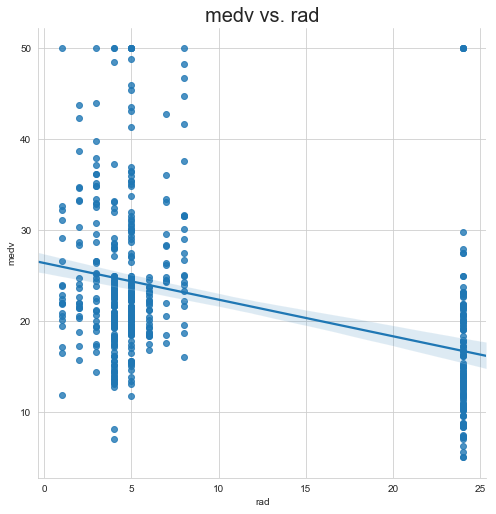

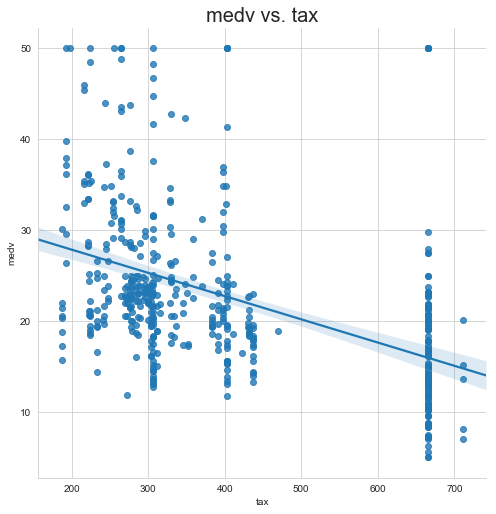

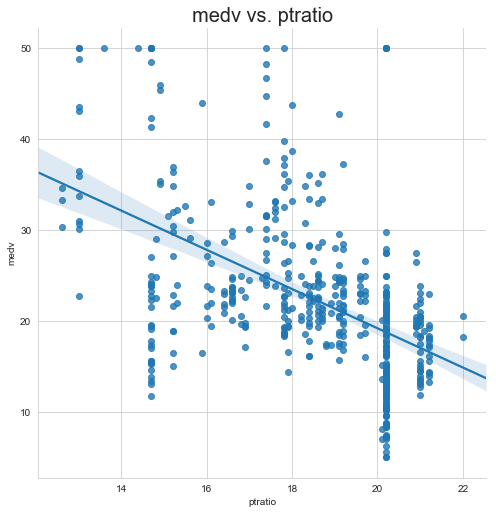

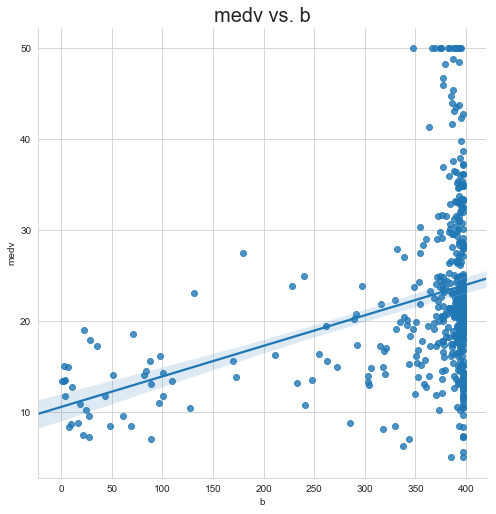

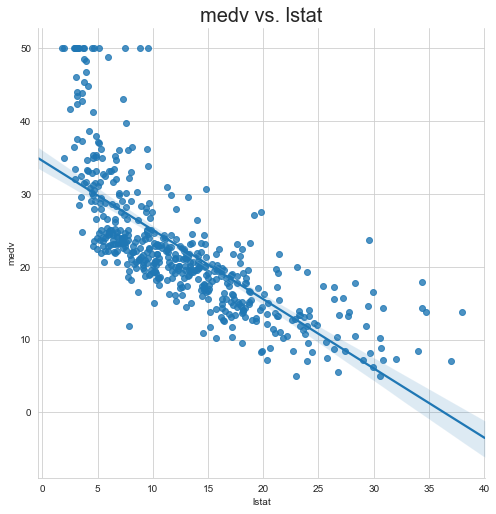

In [78]:
for col in dat.columns[:-1]:
    sns.lmplot(x=col, y='medv', data=dat, height=7, aspect=1, );
    plt.title('medv vs. ' + col, fontsize=20);

Постоим линейную регрессию медианной цены на остальные факторы (исключив переменные, которые сильно связаны друг с другом)

In [79]:
import statsmodels.formula.api as smf

In [85]:
model = smf.ols('medv ~ crim + zn + chas + rm + age + dis + ptratio + b', data=dat).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     117.0
Date:                Tue, 09 Jul 2019   Prob (F-statistic):          3.68e-109
Time:                        14:18:48   Log-Likelihood:                -1572.3
No. Observations:                 506   AIC:                             3163.
Df Residuals:                     497   BIC:                             3201.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3031      4.201     -0.548      0.5

Коэффициенты с помощью sklearn

In [5]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
features = np.array(['crim', 'zn', 'chas', 'rm', 'age', 'dis', 'ptratio', 'b'])
lr.fit(dat[features], dat.medv)
print('Const: {}'.format(lr.intercept_))
for n, coef in enumerate(features):
    print('{}: {}'.format(coef, np.round(lr.coef_[n], decimals=4)))

Const: -2.303112617466205
crim: -0.1416
zn: 0.0312
chas: 3.2172
rm: 6.9473
age: -0.0769
dis: -0.9727
ptratio: -0.8519
b: 0.0162


Для некоторых нелинейных моделей есть тоже интуитивно понятная интерпретация работы, например для решающего дерева.

In [6]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(max_depth=4) # чтобы не громоздко отрисовалось дерево
tree_model.fit(dat[features], dat.medv)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Визуализируем получившееся дерево

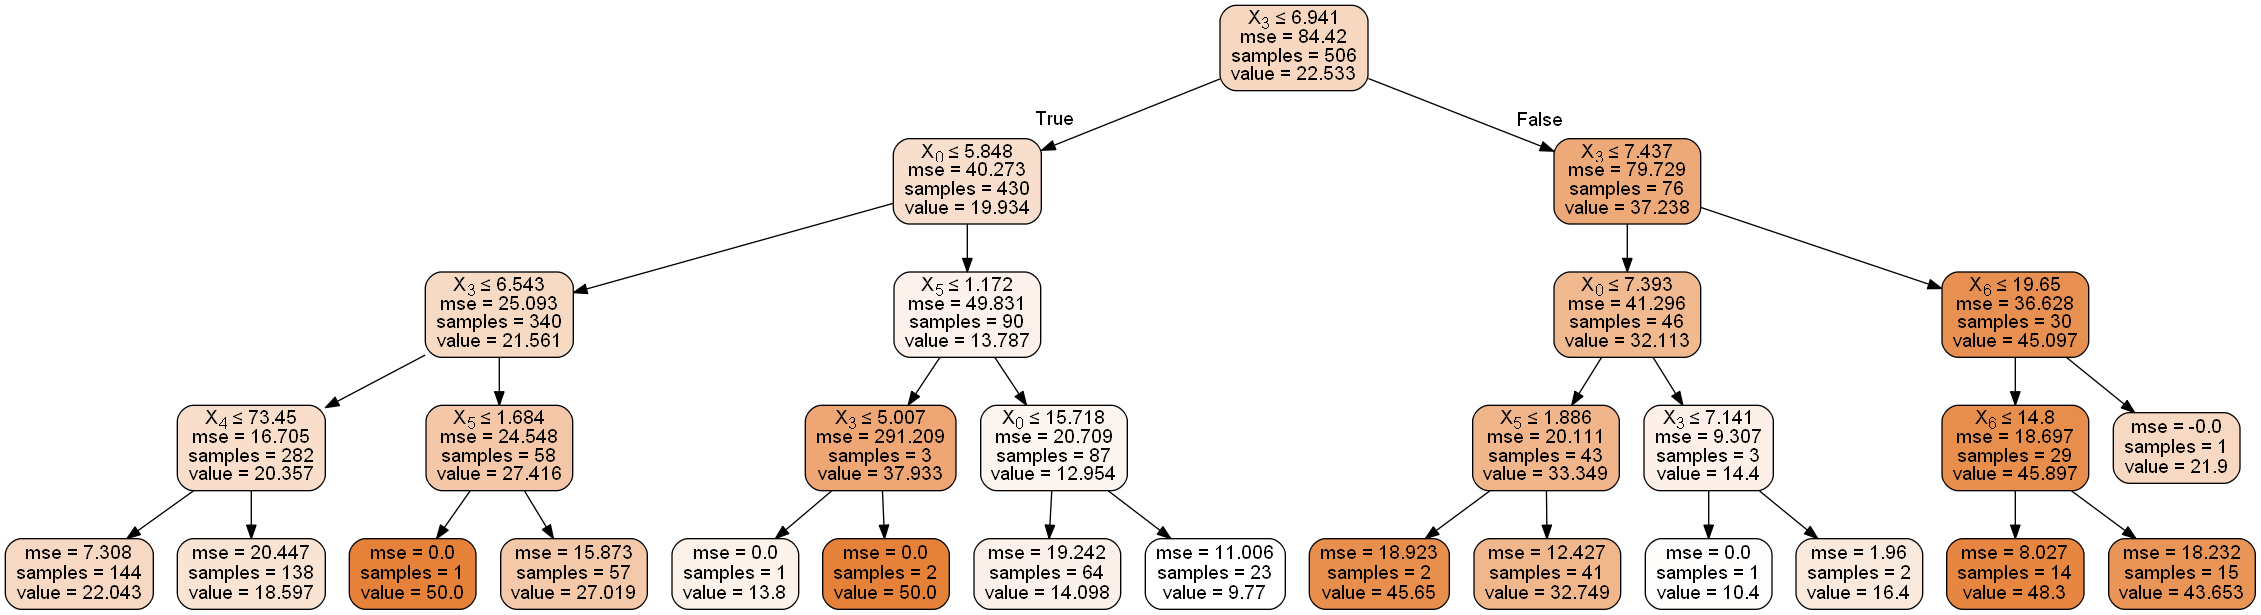

In [28]:
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Однако для случайного леса уже так нарисовать не получится, потому что итоговая модель состоит как правило из сотен деревьев. 

Существует [другой подход](http://blog.datadive.net/interpreting-random-forests/) - попытаемся представить дерево как линейную модель.

In [7]:
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(dat[features], dat.medv)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Идея метода следующая, представим итоговое предсказание как сумму среднего по выборке значения целевой переменной и вклада всех факторов:  $prediction = bias + \sum\limits_{i = 1}^d factor_{i}$

In [8]:
%%time
prediction, bias, contributions = ti.predict(rf, dat[features])

Wall time: 3.2 s


Например для 5ого объекта нашей выборки имеем:

In [9]:
print('factors_contribution: \n', contributions[5], '\n')
print('bias: \n', bias[5], '\n')
print('final_prediction: \n', prediction[5][0], '\n')
print('final_prediction = bias + sum(factors_contribution): \n', np.round(prediction[5][0], decimals=2) == 
      np.round(bias[5] + sum(contributions[5]), decimals=2))

factors_contribution: 
 [ 2.0558475   0.17477668  0.         -1.44546579  1.82604783  0.03651794
  0.68304481  0.32341284] 

bias: 
 22.553818181818187 

final_prediction: 
 26.20799999999999 

final_prediction = bias + sum(factors_contribution): 
 True


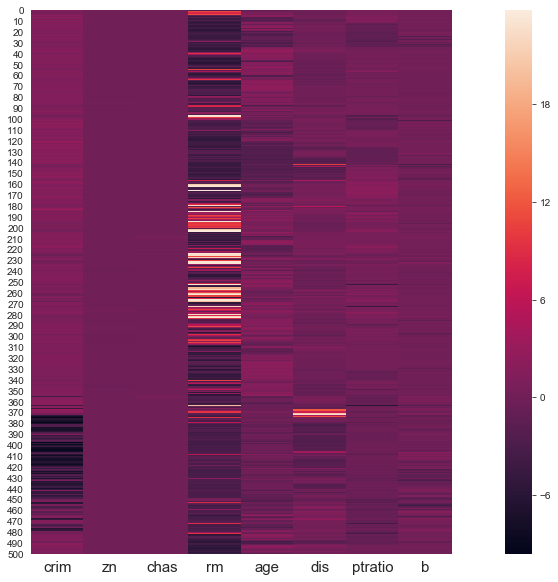

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(contributions, cmap=None)
plt.xticks(np.arange(0.5, features.shape[0]+1), features, fontsize=15);

Ещё один подход в интерпретации модели основан на важности признаков (feature_importances). Оригинально этот подход был заимствован у деревянных моделей и распространён на другие модели (shap_value). 

Смысл feature_importances - показывает как изменяется критерий качества при делении листа дерева по данному фактору и полученная важность - сумма этих изменений. Есть другой подход к [определению важности признака](http://www.machinelearning.ru/wiki/images/c/cc/PZAD2016_09_rf.pdf) - сделаем случайную перестановку значений признака и посчитаем качество модели на такой выборке, тогда важность данного признака можно посчитать как разница в качества в исходной случае и в случае с перемешиванием. 

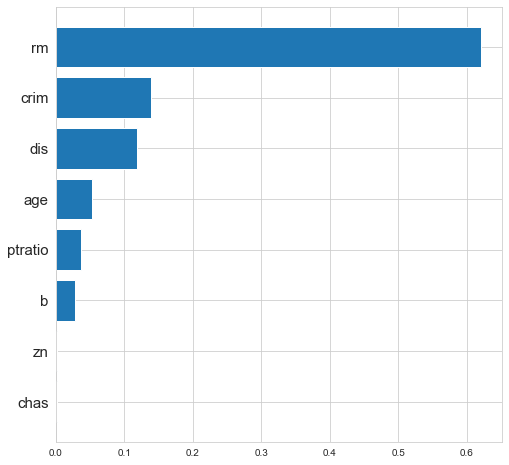

In [11]:
plt.barh(features[np.argsort(rf.feature_importances_)], np.sort(rf.feature_importances_))
plt.yticks(fontsize=15);

Оба способа интерпретации деревьев выше позволяют сделать вывод о том, что признак rm самый "важный" для модели.

Ещё одни способо интерпретации нелинейных моделей - [SHAP VALUE](https://github.com/slundberg/shap).

In [12]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(dat[features])

In [13]:
shap.initjs()
k = 1
shap.force_plot(explainer.expected_value, shap_values[k,:], dat.loc[k, features])

в данном случае, результат работы похож на treeinterpreter

Плюс этого метода - можно посмотреть как меняется значение shap_value в зависимости от значений признаков

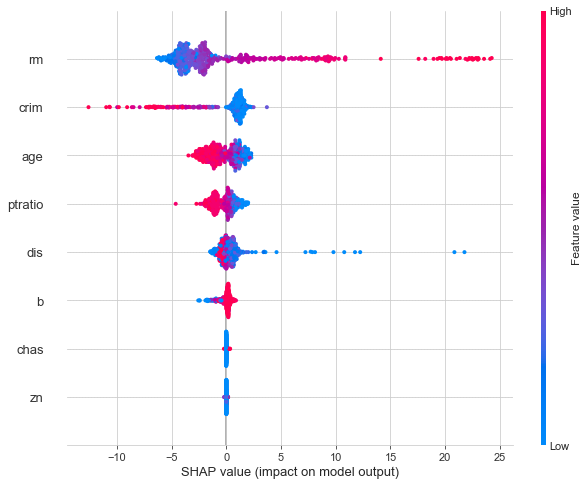

In [14]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, dat[features], auto_size_plot=False)

Из графика выше видно например, что чем больше значение переменной crim, тем меньше будет значение medv (shap value будет большим отрицательным)

Можно посмотреть тот же график отдельно по каждой переменной

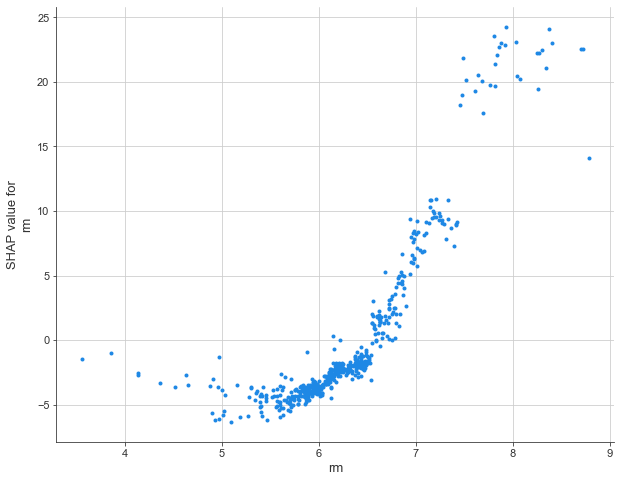

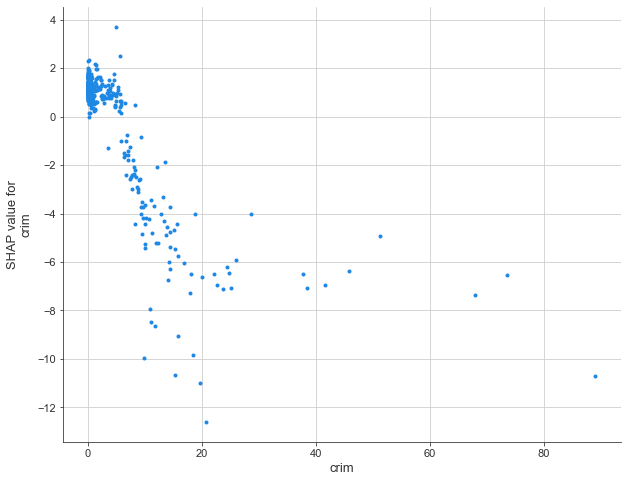

In [84]:
shap.dependence_plot('rm', shap_values, dat[features], interaction_index=None)
shap.dependence_plot('crim', shap_values, dat[features], interaction_index=None)

Можно так же смотреть на совместное влияние факторов на поведение модели, благорадя interaction_index 

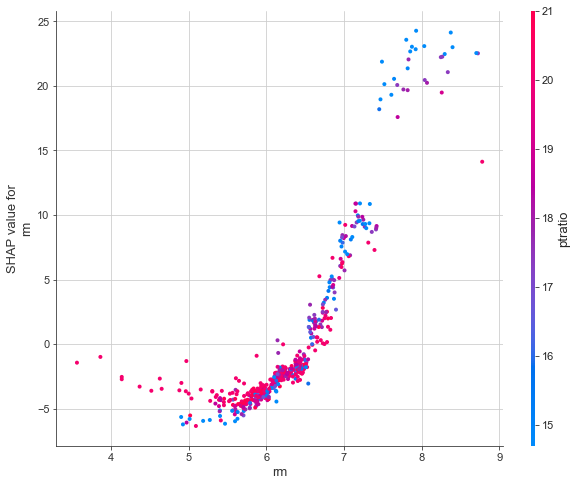

In [91]:
shap.dependence_plot('rm', shap_values, dat[features], interaction_index='ptratio')

График выше можно проинтерпретировать так: при среднем количестве комнат в доме (rm $\in [5, 7]$) показатель отношения числа учеников на число учителей (ptratio) практически не имеет влияния на модель (на стоимость жилья), при росте среднего числа комнат (rm > 7) этот показатель начинает значимо влиять на модель и чем он меньше (чем меньше учеников на одного учителя), тем дороже жильё.

#### Интерпретация моделей в задаче анализа текста

Shap value является очень гибким инструментом интерпретации и применяется помимо рассмотренного выше так же в задачах компьютерного зрения и анализе текстов. Для интерпретации моделей с задачах анализа текстов рассмотрим похожий инструмент - [eli5](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial).

Будем исследовать набор 20 newsgroups - содержащий тексты, относящиеся к 20 категориям.

In [291]:
from sklearn.datasets import fetch_20newsgroups
news = fetch_20newsgroups()

Создадим словарь для названия классов

In [292]:
target_names_dict = dict(zip(np.arange(len(news['target_names'])).astype(str), news['target_names']))
target_names_dict

{'0': 'alt.atheism',
 '1': 'comp.graphics',
 '2': 'comp.os.ms-windows.misc',
 '3': 'comp.sys.ibm.pc.hardware',
 '4': 'comp.sys.mac.hardware',
 '5': 'comp.windows.x',
 '6': 'misc.forsale',
 '7': 'rec.autos',
 '8': 'rec.motorcycles',
 '9': 'rec.sport.baseball',
 '10': 'rec.sport.hockey',
 '11': 'sci.crypt',
 '12': 'sci.electronics',
 '13': 'sci.med',
 '14': 'sci.space',
 '15': 'soc.religion.christian',
 '16': 'talk.politics.guns',
 '17': 'talk.politics.mideast',
 '18': 'talk.politics.misc',
 '19': 'talk.religion.misc'}

In [293]:
%%time
dat = pd.DataFrame(np.c_[np.array(news['data']), news['target']], columns=['text', 'target'])
dat['target_names'] = dat.target.map(target_names_dict)

Wall time: 10.7 s


In [294]:
dat.head()

,text,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


Посмотрим на пример текста по каждой из тем

In [295]:
for key in target_names_dict:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('            ', target_names_dict[key])
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print(dat.text.loc[dat.target == key].values[0])
    print()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             alt.atheism
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
From: mathew <mathew@mantis.co.uk>
Subject: Re: <Political Atheists?
Organization: Mantis Consultants, Cambridge. UK.
X-Newsreader: rusnews v1.01
Lines: 22

kmr4@po.CWRU.edu (Keith M. Ryan) writes:
> ( I am almost sure that Zyklon-B is immediate and painless method of 
> death. If not, insert soem other form. )
> 
>         And, ethnic and minority groups have been killed, mutilated and 
> exterminated through out history, so I guess it was not unusual.
> 
>         So, you would agree that the holocost would be allowed under the US 
> Constitution?  [ in so far, the punishment. I doubt they recieved what would 
> be considered a "fair" trial by US standards.

Don't be so sure.  Look what happened to Japanese citizens in the US during
World War II.  If you're prepared to say "Let's round these people up and
stick them in a concentration camp without trial", it's only a short s



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             rec.autos
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             rec.motorcycles
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
From: irwin@cmptrc.lonestar.org (Irwin Arnstein)
Su



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             sci.space
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
From: jcm@head-cfa.harvard.edu (Jonathan McDowell)
Subject: Re: Shuttle Launch Question
Organization: Smithsonian Astrophysical Observatory, Cambridge, MA,  USA
Distribution: sci
Lines: 23

From article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):
>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...
>>>"Clear caution & warning memory.  Verify no unexpected
>>>errors. ...".  I am wondering what an "expected error" might
>>>be.  Sorry if this is a really dumb question, but
> 
> Parity errors in memory or previously known conditions that were waivered.
>    "Yes that is an error, but we already knew about it"
> I'd be curious as to what the real meaning of the quote is.
> 
> tom


My understanding is that the 'expected errors' are basically
known bugs in the warning system software - things are checked
that don't have the right



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             talk.politics.misc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
From: joec@hilbert.cyprs.rain.com ( Joe Cipale)
Subject: Re: Clayton Need not Retract
Organization: Cypress Semi, Beaverton OR
Lines: 13

In article <Apr.9.08.39.25.1993.15639@romulus.rutgers.edu> kaldis@romulus.rutgers.edu (Theodore A. Kaldis) writes:
>civilized society.  The _ONLY_ way a homosexual can maintain even a
>modicum of respectability is by remaining in the closet.
>-- 
>  The views expressed herein are   |  Theodore A. Kaldis
>  my own only.  Do you seriously   |  kaldis@remus.rutgers.edu
>  believe that a major university  |  {...}!rutgers!remus.rutgers.edu!kaldis
>  as this would hold such views??? |

Once again, it appears that the one-eyed man has appeared in the land of the sighted
and for some strange resaon has appointed himself the ruler and supreme power.

Joe Cipale


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             talk.religion.misc
~~~

Сделаем небольшую чистку текста

In [296]:
import re
for i in tqdm_notebook(range(dat.shape[0])):
    dat.text[i] = re.sub(r'[-\d@,\:\/]', '', dat.text[i].replace('-', '')).replace('From', '').replace('Subject', '').replace('Lines', '').lower()

In [298]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [299]:
%%time
tf_idf = TfidfVectorizer(min_df=20)
tf_idf.fit(dat.text)
X = tf_idf.transform(dat.text)
y = dat.target_names

Wall time: 4.63 s


Обучим логистическую регрессию

In [320]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Посмотрим на самые значимые слова для каждой темы

In [6]:
import eli5

In [326]:
eli5.show_weights(model, top=10, target_names=model.classes_, vec=tf_idf)

Посмотрим на пример ключевых слов в тексте

In [348]:
eli5.show_prediction(model, dat.text[6], vec=tf_idf, target_names=model.classes_, 
                     top_targets=3, top=10)